In [119]:
%%time
import os
import subprocess
import numpy as np
import pandas as pd
import scipy.io.wavfile
from sys import getsizeof
from scipy import signal
from IPython.display import Audio
import csv
import matplotlib.pyplot as plt
import seaborn as sns


# feature extraction with pyAudioAnalysis:
from pyAudioAnalysis import ShortTermFeatures

import cudf
import cuspatial
import cupy as cp
import cusignal

print(cuspatial.point_in_polygon_bitmap)
print(cudf.__version__)

<function point_in_polygon_bitmap at 0x7f38dfee4510>
0.13.0
CPU times: user 263 µs, sys: 86 µs, total: 349 µs
Wall time: 300 µs


In [120]:
%%time
df = pd.read_csv("../../data/features.csv")

CPU times: user 680 ms, sys: 3.25 ms, total: 683 ms
Wall time: 681 ms


In [121]:
df.head(2)

,zcr,energy,energy_entropy,spectral_centroid,spectral_spread,spectral_entropy,spectral_rolloff,mfcc_1,mfcc_2,mfcc_3,...,chroma_12,chroma_std,sox_dc_offset,sox_min_level,sox_max_level,sox_rms_lev_db,sox_rms_pk_db,sox_rms_tr_db,sox_crest_factor,filename
0,0.183709,0.001353,0.363362,0.288751,0.322937,0.584234,0.075542,-20.353333,1.132189,-0.841119,...,0.000003,0.000231,-0.003506,-0.999969,0.594574,-28.65,-12.16,-54.30,27.06,0_0_5.4_47189.wav
1,0.052367,0.020259,2.843993,0.135859,0.166813,0.219738,0.016375,-17.936578,2.228626,0.233894,...,0.000015,0.000009,-0.000095,-0.999969,0.990112,-16.93,-7.00,-31.91,7.03,0_102_4.76_41357.wav


In [122]:
df.min()

zcr                                  0
energy                               0
energy_entropy                      -0
spectral_centroid           0.00750807
spectral_spread              0.0301062
spectral_entropy                    -0
spectral_rolloff                     0
mfcc_1                        -50.5964
mfcc_2                        -1.96778
mfcc_3                        -5.44783
mfcc_4                        -3.65004
mfcc_5                        -2.80623
mfcc_6                        -2.16861
mfcc_7                        -2.04968
mfcc_8                         -1.8308
mfcc_9                        -1.57045
mfcc_10                       -1.25664
mfcc_11                       -1.32794
mfcc_12                        -1.1507
mfcc_13                       -1.09282
chroma_1                   2.29364e-09
chroma_2                   8.61264e-10
chroma_3                   1.40055e-09
chroma_4                   1.97035e-09
chroma_5                   1.39426e-09
chroma_6                 

In [123]:
# need to know how many outliers per column
print((df["sox_rms_lev_db"] == float("-inf")).sum())
print((df["sox_rms_pk_db"] == float("-inf")).sum())
print((df["sox_rms_tr_db"] == float("-inf")).sum())
print((df["sox_max_level"] == float("0")).sum())
print((df["zcr"] == float("0")).sum())

22
22
29
25
22


In [124]:
# need to drop outliers
df.drop(df[df["sox_rms_lev_db"] == float("-inf")].index, inplace=True)
df.drop(df[df["sox_rms_tr_db"] == float("-inf")].index, inplace=True)
df.drop(df[df["sox_max_level"] == float("0")].index, inplace=True)

In [125]:
print((df["sox_rms_lev_db"] == float("-inf")).sum())
print((df["sox_rms_pk_db"] == float("-inf")).sum())
print((df["sox_rms_tr_db"] == float("-inf")).sum())
print((df["sox_max_level"] == float("0")).sum())
print((df["zcr"] == float("0")).sum())

0
0
0
0
0


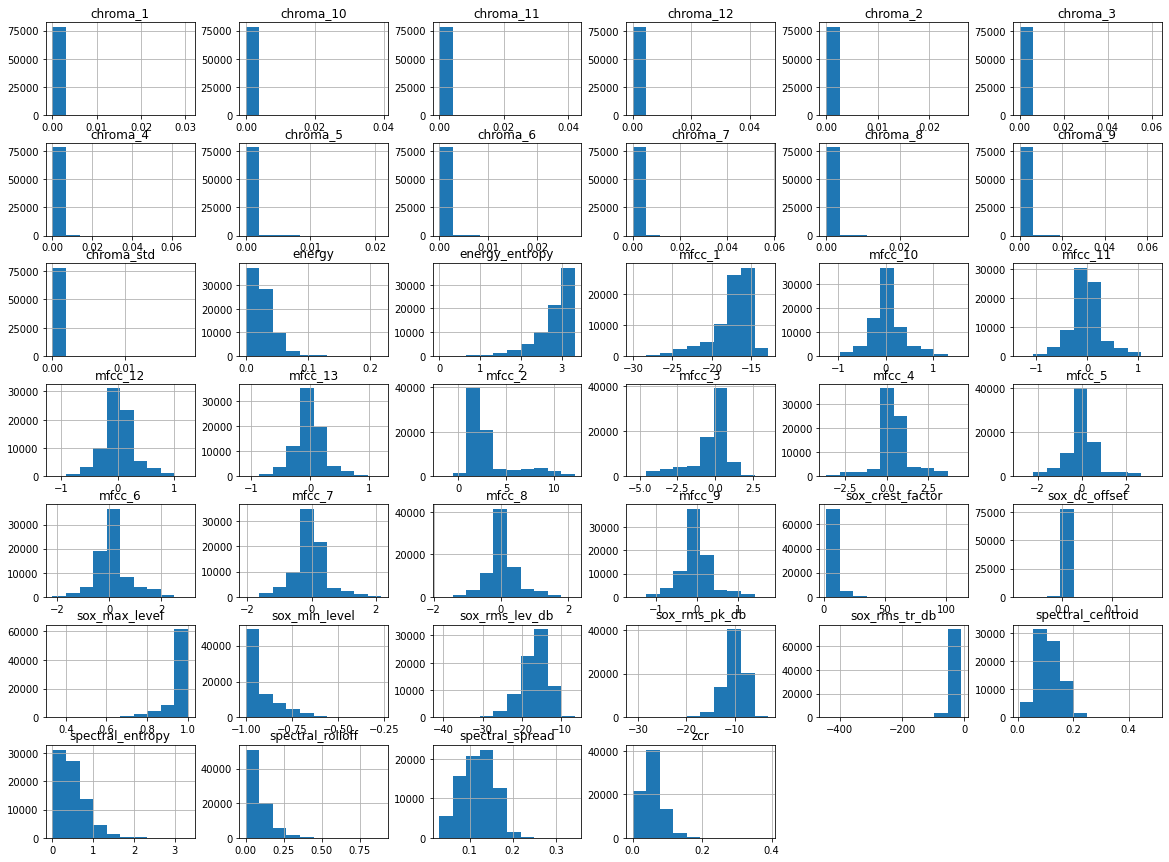

In [126]:
# value distributions
df.drop(["filename"], 1).hist(figsize=(20,15));

In [127]:
# get values range per column
df.drop(["filename"], 1).max() - df.drop(["filename"], 1).min()

zcr                    0.389135
energy                 0.217370
energy_entropy         3.321338
spectral_centroid      0.487521
spectral_spread        0.313479
spectral_entropy       3.316996
spectral_rolloff       0.888433
mfcc_1                17.115091
mfcc_2                14.157643
mfcc_3                 8.929311
mfcc_4                 8.157174
mfcc_5                 6.095287
mfcc_6                 5.177848
mfcc_7                 4.216649
mfcc_8                 4.025014
mfcc_9                 3.311555
mfcc_10                2.855166
mfcc_11                2.663992
mfcc_12                2.386064
mfcc_13                2.292836
chroma_1               0.030577
chroma_2               0.026300
chroma_3               0.061512
chroma_4               0.068006
chroma_5               0.020958
chroma_6               0.027713
chroma_7               0.057322
chroma_8               0.036775
chroma_9               0.063546
chroma_10              0.039250
chroma_11              0.042017
chroma_1

In [128]:
useless_features = ["chroma_1",
                    "chroma_2",
                    "chroma_3",
                    "chroma_4",
                    "chroma_5",
                    "chroma_6",
                    "chroma_7",
                    "chroma_8",
                    "chroma_9",
                    "chroma_10",
                    "chroma_11",
                    "chroma_12",
                    "chroma_std",
                    "sox_dc_offset",
                    "sox_crest_factor", 
                    "sox_max_level",
                    "sox_min_level",
                    "sox_rms_tr_db"
                   ]

In [129]:
# need to drop useless features
for j in useless_features:
    df.drop([j],axis=1,inplace=True)

In [154]:
# reindex columns to alphabetical order
df = df.reindex(sorted(df.columns), axis=1)
column_names = list(df.columns)
column_names

['energy',
 'energy_entropy',
 'filename',
 'mfcc_1',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_13',
 'mfcc_2',
 'mfcc_3',
 'mfcc_4',
 'mfcc_5',
 'mfcc_6',
 'mfcc_7',
 'mfcc_8',
 'mfcc_9',
 'sox_rms_lev_db',
 'sox_rms_pk_db',
 'spectral_centroid',
 'spectral_entropy',
 'spectral_rolloff',
 'spectral_spread',
 'zcr']

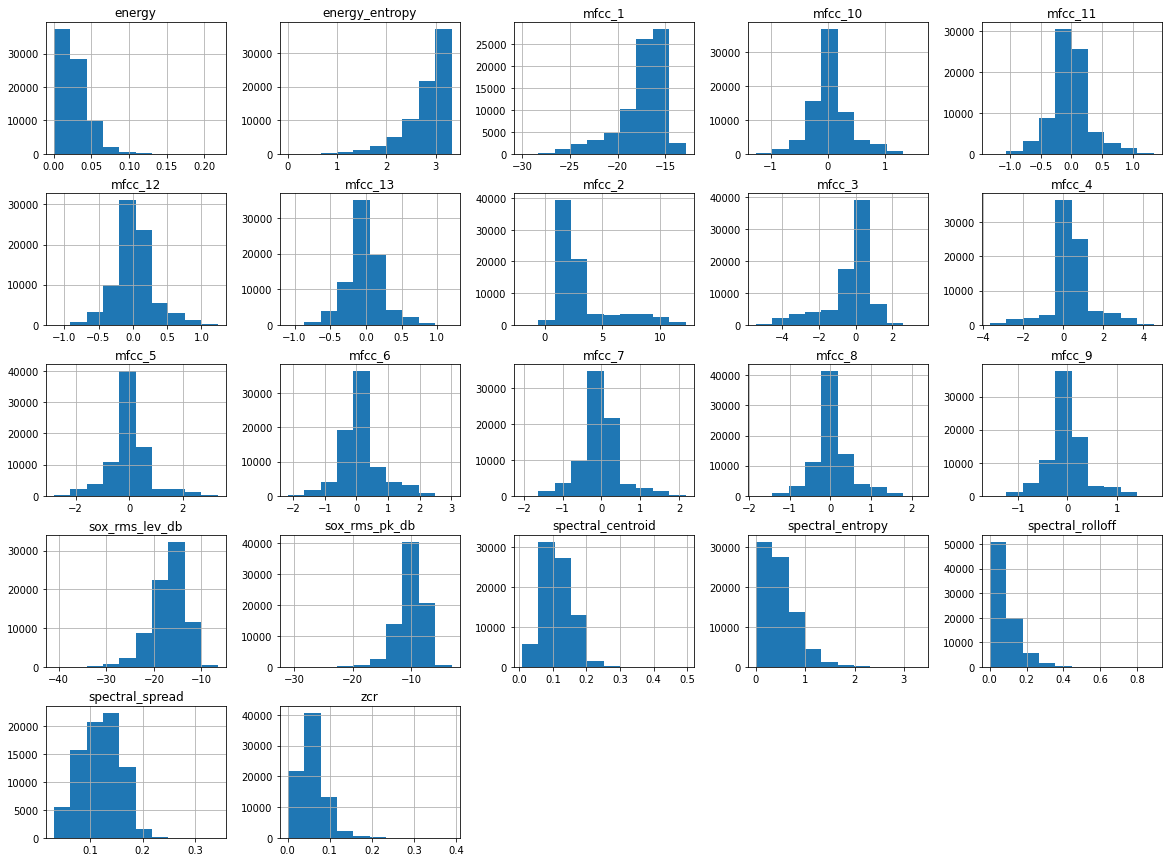

In [150]:
# value distributions
df.drop(["filename"], 1).hist(figsize=(20,15));

In [131]:
###
### Need to clean up outliers
###

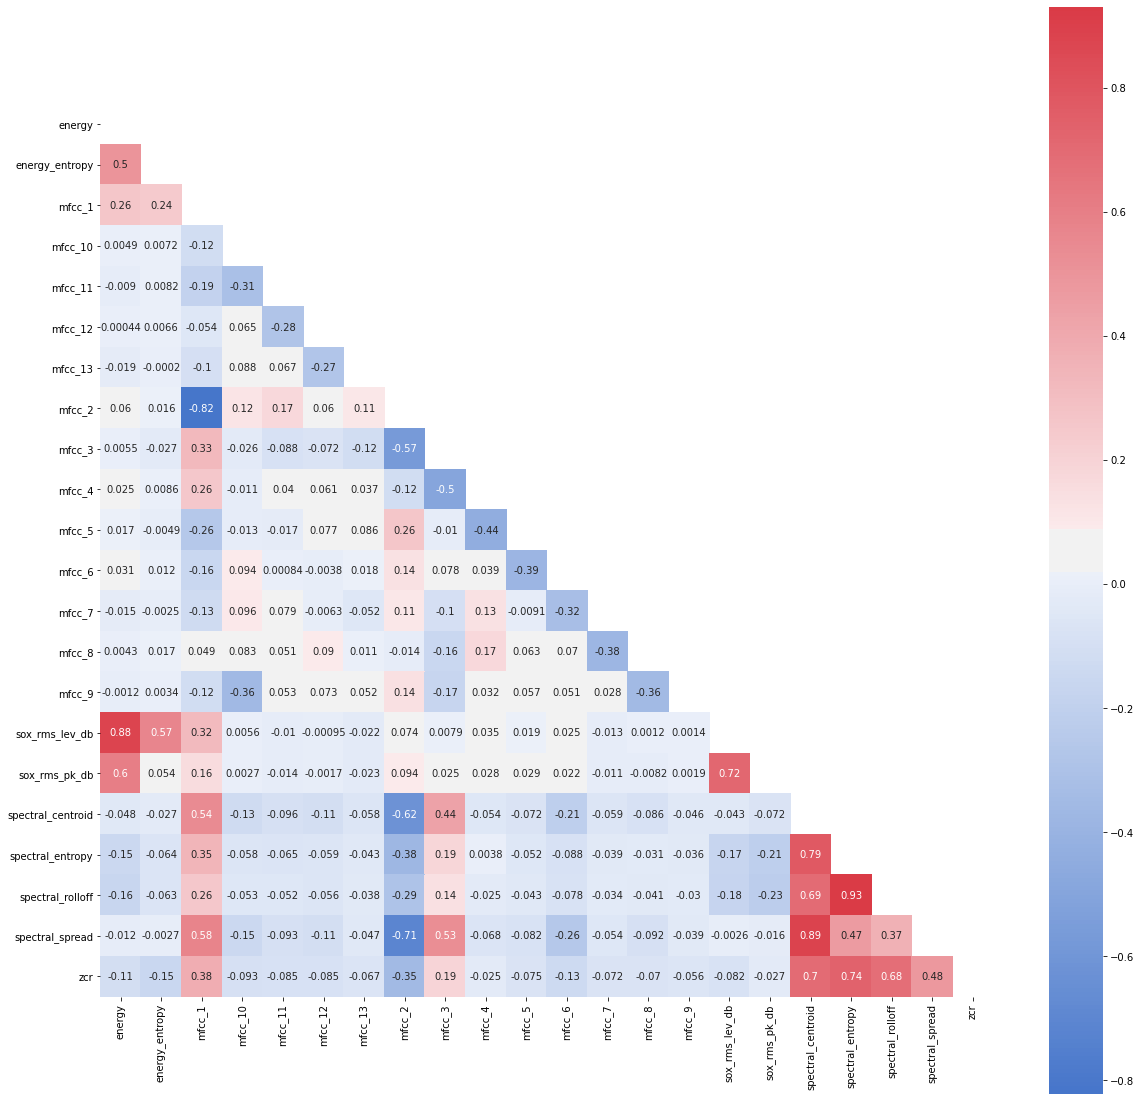

In [151]:
plt.figure(figsize = (20,20))
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(255, 10, as_cmap = True)
sns.heatmap(\
            df.corr(), \
            annot = True, \
            square = True, \
            mask = mask, \
            cmap = cmap \
).get_figure();

In [152]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# eda_scaler = StandardScaler()
eda_scaler = MinMaxScaler()

df_scaled = eda_scaler.fit_transform(df.drop(["filename"], 1))

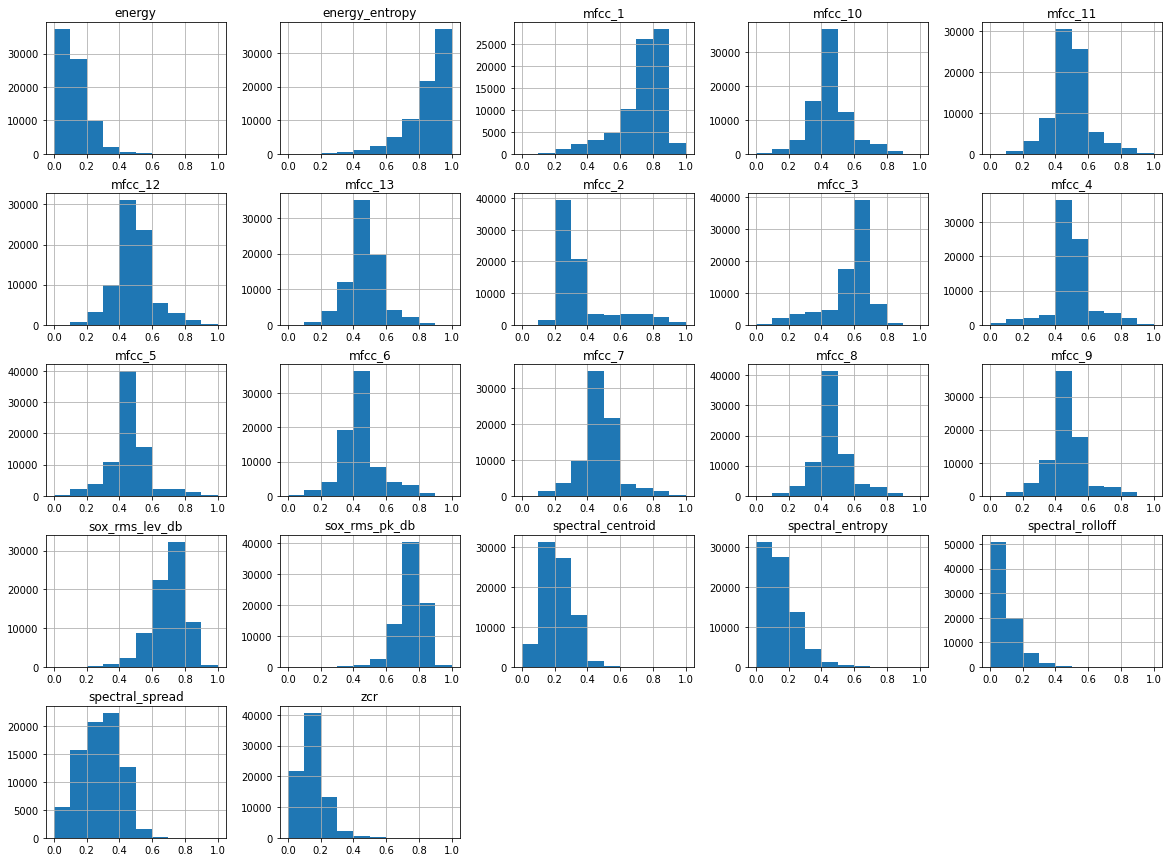

In [156]:
column_names.remove("filename")
pd.DataFrame(df_scaled, columns = column_names).hist(figsize=(20,15));

In [ ]:
### remember to save original df, NOT scaled!